In [380]:
import torch
import copy

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import numpy as np
import glob, os
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from torch import nn, optim

import torch.nn.functional as F

In [381]:
torch.__version__

'1.6.0'

In [383]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
dir = './datasets/fsm/seq/*'
os.getcwd()

'/home/yujeong/Frequent-Subgraph-Mining-Using-Deep-Learning'

In [384]:
print(dir)

./datasets/fsm/seq/*


In [385]:
alpha = list(string.ascii_uppercase)
chr2index = {alpha[i]:i for i in range(len(alpha))}

In [386]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [387]:
def chr2OH(alphabet):
    oh = [0 for i in range(len(alpha))]
    index = chr2index[alphabet]
    oh[index] = 1
    return oh


In [392]:
# file read
all_names = []
all_data = []
sequence_length = []
alpha = list(string.ascii_uppercase)
data_length = len(glob.glob(dir))
file_predix = './datasets/fsm/seq'
files = glob.glob(dir)


In [393]:
files = glob.glob(dir)
for file in files:
    datasets = []
    all_names.append(file.split('\\')[-1].replace('.txt', ''))
    for rf in open(file, 'r'):
        (u, v, w) = rf[1:-2].split(', ')
        datasets.append(chr2OH(u[1]) + chr2OH(v[1]) +[float(w)])
        #datasets.append([chr2index[u[1]], chr2index[v[1]], float(w)])
    sequence_length.append(len(datasets))
    all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

max_sequence_length = max(sequence_length)
zeros = np.zeros(53)
     

for ind, data in enumerate(all_data):
    if len(data) != max_sequence_length:
        for i in range(len(data), max_sequence_length):
            all_data[ind] = np.vstack([all_data[ind], zeros])

all_d = []
for ind, data in enumerate(all_data):
    all_d.append(data.flatten())
    #all_d[ind] = data.flatten()
    
all_d[0]
all_d = np.array(all_d)
print(type(all_d))
all_d[0]

<class 'numpy.ndarray'>


array([ 1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , 10.9955,  0.    ,  1.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [394]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [395]:
x_train, x_test, train_name, test_name = train_test_split(all_data, all_names, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)
type(x_train)

numpy.ndarray

In [396]:
tr_names= []
for name in train_name:
    tr_names.append(name.split('graph')[0])
    #tr_names.append(name.split('-')[0].replace('graph', ''))

In [397]:
tr_names[0]

'./datasets/fsm/seq/0'

In [398]:
max_sequence_length = max(sequence_length) #sequence_len
n_features = 3
batch_size = 32
#epochs = 200
epochs = 10
steps_per_epoch = len(x_train) #n_sequence
max_sequence_length

5

In [399]:

def create_dataset_1(nparrays):
    dataset = [torch.tensor(s).unsqueeze(0).float() for s in nparrays]
  #step_per_epoch, seq_len, llen, n_features = torch.stack(dataset).shape
    #n_seq, m ,seq_len, n_features = print(torch.stack(dataset).shape)
    print(torch.stack(dataset).shape)
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    #print( n_seq, m , seq_len, n_features )
    return dataset, seq_len, n_features

In [400]:

def create_dataset_0(nparrays):
    #dataset = [torch.tensor(s).float() for s in nparrays]
  #step_per_epoch, seq_len, llen, n_features = torch.stack(dataset).shape
    dataset = torch.from_numpy(nparrays)
    #n_features  = torch.stack(dataset).shape
    shape_list = list(dataset.shape)
    print("dataset: " , shape_list)
    seq_len = shape_list[1]
    n_features = shape_list[2]
    return dataset, seq_len, n_features

In [401]:
x_train_2d, x_test_2d, train_name_2d, test_name_2d = train_test_split(all_data, all_names, test_size=0.3)
x_test_2d, x_val_2d, test_name_2d, val_name_2d = train_test_split(x_test_2d, test_name_2d, test_size=0.33)

In [402]:
x_train_2d, x_test_2d, train_name_2d, test_name_2d = train_test_split(all_data, all_names, test_size=0.3)
x_test_2d, x_val_2d, test_name_2d, val_name_2d = train_test_split(x_test_2d, test_name_2d, test_size=0.33)
type(x_train_2d)
train_dataset_2d, seq_len_2d, n_features_2d = create_dataset_0(x_train_2d)
val_dataset_2d, _, _ = create_dataset_0(x_val_2d)

print(seq_len_2d)
print(n_features_2d)
print(train_dataset_2d[0])

dataset:  [525, 5, 53]
dataset:  [75, 5, 53]
5
53
tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  2.0282],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
    

In [403]:
x_train_1d , x_test_1d , train_name_1d , test_name_1d = train_test_split(all_d, all_names, test_size=0.3)
x_test_1d , x_val_1d , test_name_1d , val_name_1d  = train_test_split(x_test_1d, test_name_1d, test_size=0.33)
type(x_train_1d )
train_dataset_1d , seq_len_1d , n_features_1d  = create_dataset_1(x_train_1d )
val_dataset_1d , _, _ = create_dataset_1(x_val_1d )
train_dataset_1d[0]
print(seq_len_1d)
print(n_features_1d)

torch.Size([525, 1, 265])
torch.Size([75, 1, 265])
1
265


In [420]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):

        x = x.reshape((1, self.seq_len, self.n_features))
        
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        
        return hidden_n.reshape((self.seq_len, self.embedding_dim))

In [421]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
       
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.n_features, self.hidden_dim))
        return self.output_layer(x)

In [422]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [423]:

model = RecurrentAutoencoder(seq_len_1d  , n_features_1d , 128) #alphabe 26 -> 26  weight 1
model = model.to(device)

In [424]:
class F1_Loss(nn.Module):

    def __init__(self, epsilon=1e-1):
        super().__init__()
        self.epsilon = epsilon
        
    def forward(self, y_pred, y_true):
      
        print(y_pred);
        y_true = y_true.flatten().to(torch.long)
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        
        y_true = F.one_hot(y_true, 10).to(torch.float64)
        y_pred = F.softmax(y_pred, dim=1)
        tp = (y_true * y_pred).sum(dim=0).to(torch.float64)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float64)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float64)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float64)
        
        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)
        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        
        print(precision);
        print(recall);
     
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        '''
        precision = precision.clamp(min=self.epsilon, max=1-self.epsilon)
        recall = recall.clamp(min=self.epsilon, max=1-self.epsilon)
        '''
        
        '''
        for i in range(len(y_pred_pc)):
            y_pred_pc[i] = round(y_pred_pc[i])
            
        precision_pc = precision_score(y_true_pc, y_pred_pc, average='macro')
        recall_pc = recall_score(y_true_pc, y_pred_pc, average='macro')
        '''
        return 1 - f1.mean(), 1- precision.mean(), 1- recall.mean()
    
f1_loss = F1_Loss().cuda()

In [425]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  #criterion = nn.L1Loss(reduction='sum').to(device)
    criterion = nn.MSELoss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            loss.backward()
            optimizer.step()
            
        
            train_losses.append(loss.item())
            
        val_losses = []
        model = model.eval()
    
        with torch.no_grad():
            for seq_true in val_dataset:
            
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
            
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
    
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [426]:
model, history = train_model(
  model, 
  train_dataset_1d, 
  val_dataset_1d, 
  n_epochs= 200
)

Epoch 1: train loss 49.57662234901672 val loss 49.279576223641634
Epoch 2: train loss 41.385006396387304 val loss 45.95118259285887
Epoch 3: train loss 38.21369356794726 val loss 42.82547678108017
Epoch 4: train loss 36.49317791628695 val loss 41.85345267340541
Epoch 5: train loss 35.40774552294186 val loss 41.12230538119872
Epoch 6: train loss 33.66084140324167 val loss 38.22598066240549
Epoch 7: train loss 30.69789760216361 val loss 34.75031597107649
Epoch 8: train loss 27.612148590783278 val loss 31.21819806824128
Epoch 9: train loss 24.426582882581723 val loss 27.282702510605255
Epoch 10: train loss 20.239744762666522 val loss 22.60461970668286
Epoch 11: train loss 16.384484286579703 val loss 18.15005681787928
Epoch 12: train loss 13.11575541614954 val loss 14.464010938232144
Epoch 13: train loss 10.266243979654142 val loss 11.162878445858757
Epoch 14: train loss 7.814675925051173 val loss 8.407288917054732
Epoch 15: train loss 5.808023443817206 val loss 6.179627579140166
Epoch 16:

Epoch 118: train loss 0.010191293994264146 val loss 0.00857501927142342
Epoch 119: train loss 0.009864956755634575 val loss 0.008074396188991766
Epoch 120: train loss 0.009662691714862982 val loss 0.008960107261470208
Epoch 121: train loss 0.010291289408037084 val loss 0.009816943405506512
Epoch 122: train loss 0.00990407170567085 val loss 0.00894704477939134
Epoch 123: train loss 0.00974060616001398 val loss 0.008629404391006876
Epoch 124: train loss 0.00967455258354589 val loss 0.009649477891313533
Epoch 125: train loss 0.010075054896851291 val loss 0.00940046003398796
Epoch 126: train loss 0.00939349937177862 val loss 0.008873293266321221
Epoch 127: train loss 0.009816896659294364 val loss 0.00942448843891422
Epoch 128: train loss 0.009355261476871202 val loss 0.008574995781915883
Epoch 129: train loss 0.00972086815582034 val loss 0.008853263476242622
Epoch 130: train loss 0.009570053876932001 val loss 0.00812633172608912
Epoch 131: train loss 0.009667934919929221 val loss 0.0079454

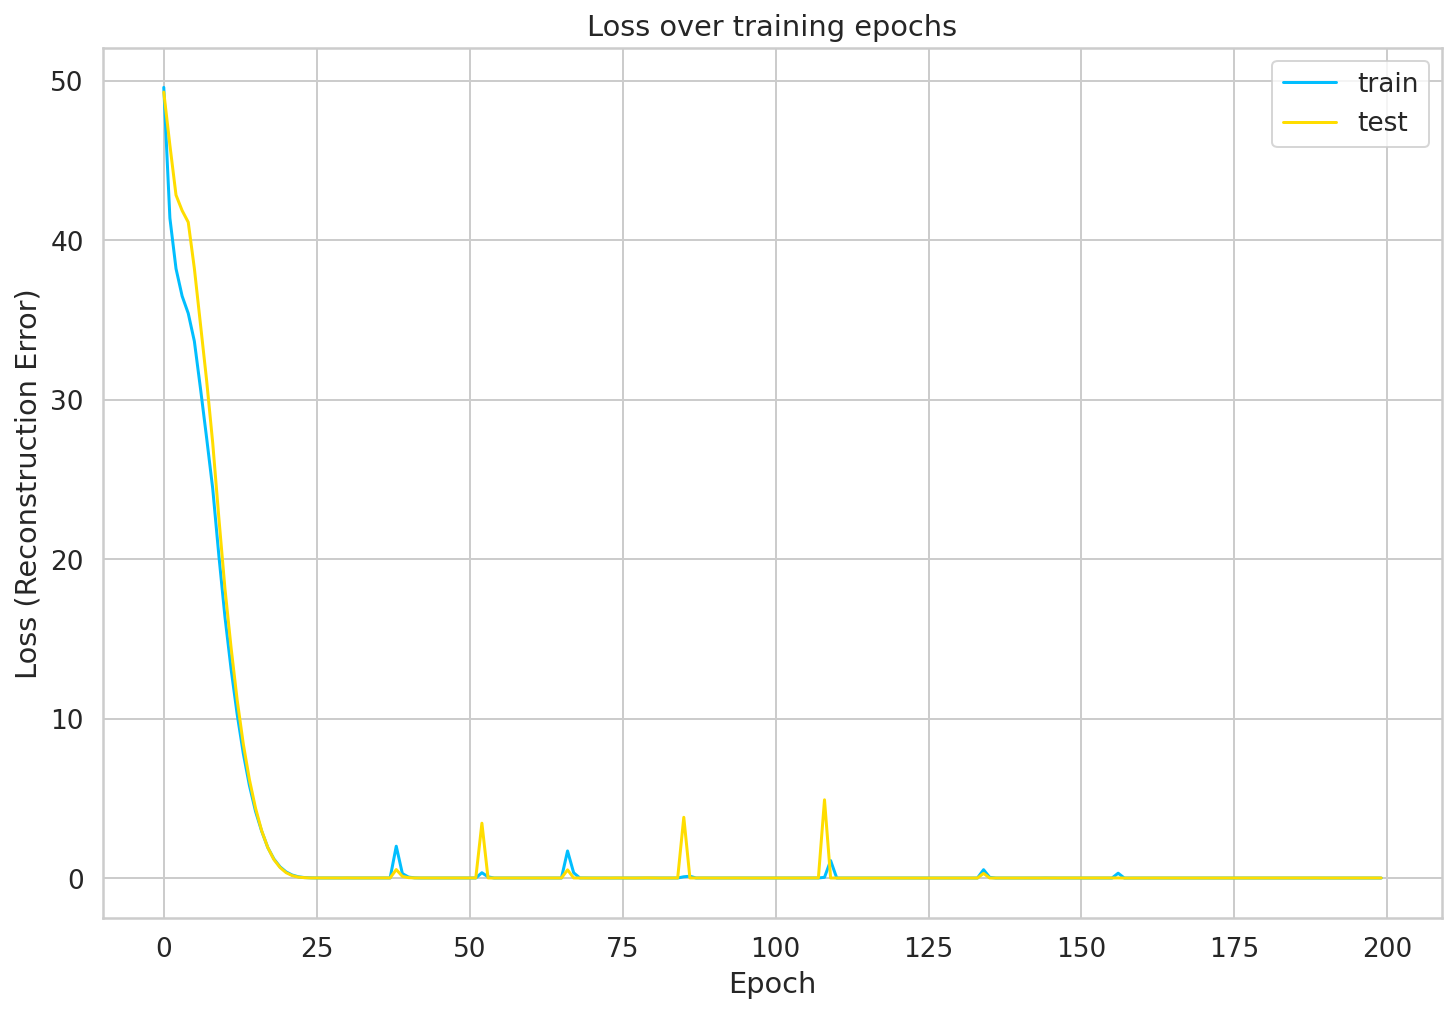

<Figure size 864x576 with 0 Axes>

In [427]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss (Reconstruction Error)')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()
plt.savefig('model_onehot_x1data_MSE_epoch200.png', dpi =200)

In [428]:
model_path =  './models/model_onehot_x1data_MSE_epoch200.pth'
torch.save(model, model_path)

In [126]:
model = torch.load(model_path)  


In [127]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.MSELoss(reduction='mean').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [121]:
THRESHOLD = 26
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

NameError: name 'test_normal_dataset' is not defined

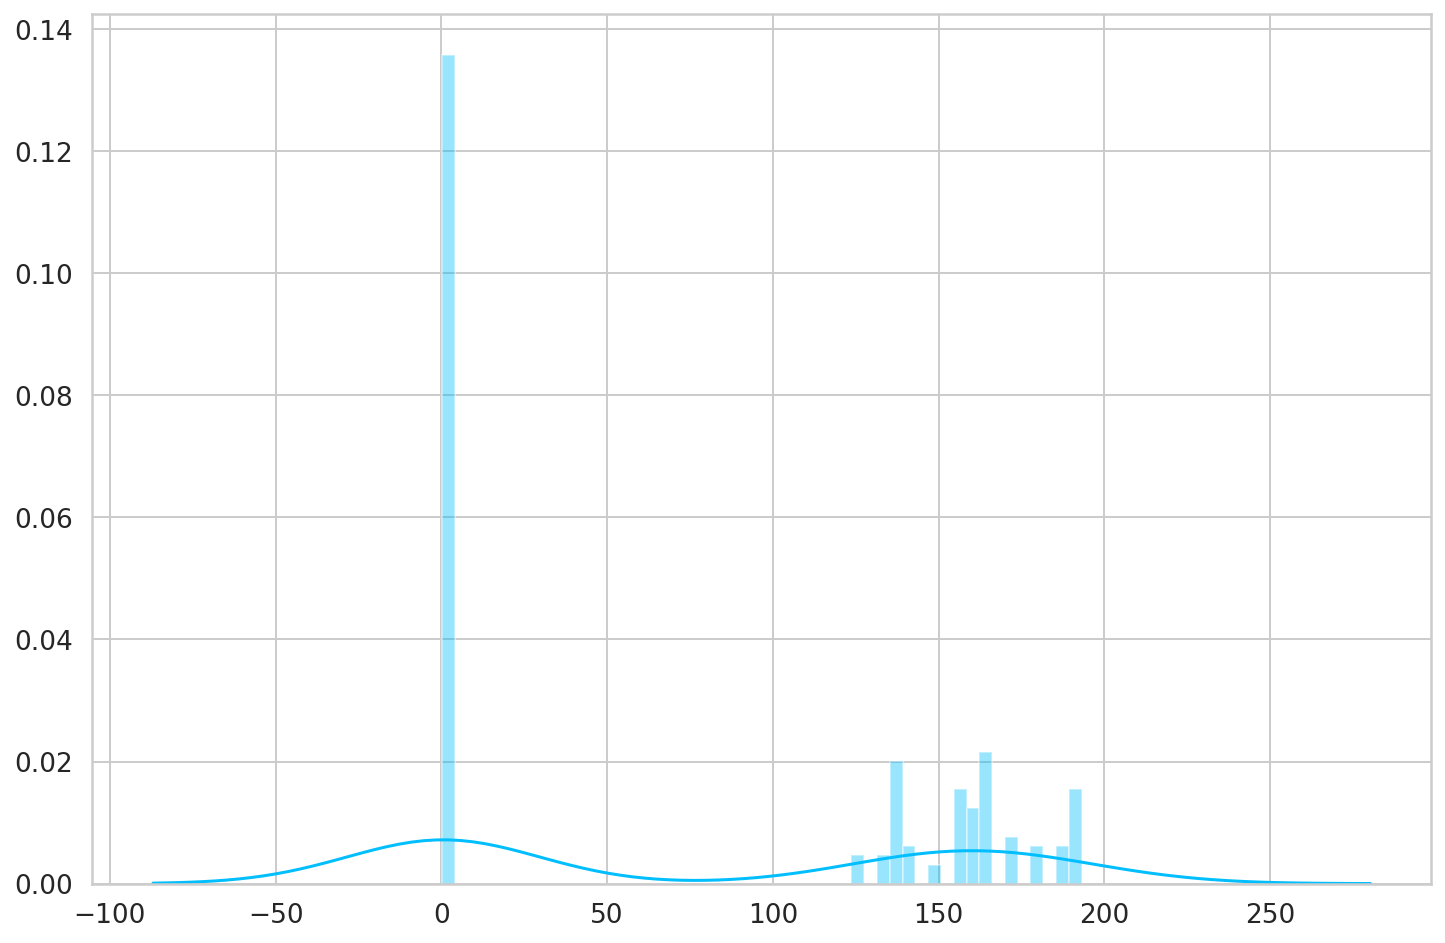

In [128]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);